/tmp/ipykernel_366051/3710048421.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('test_with_predictions_with_correct_mapping.csv')


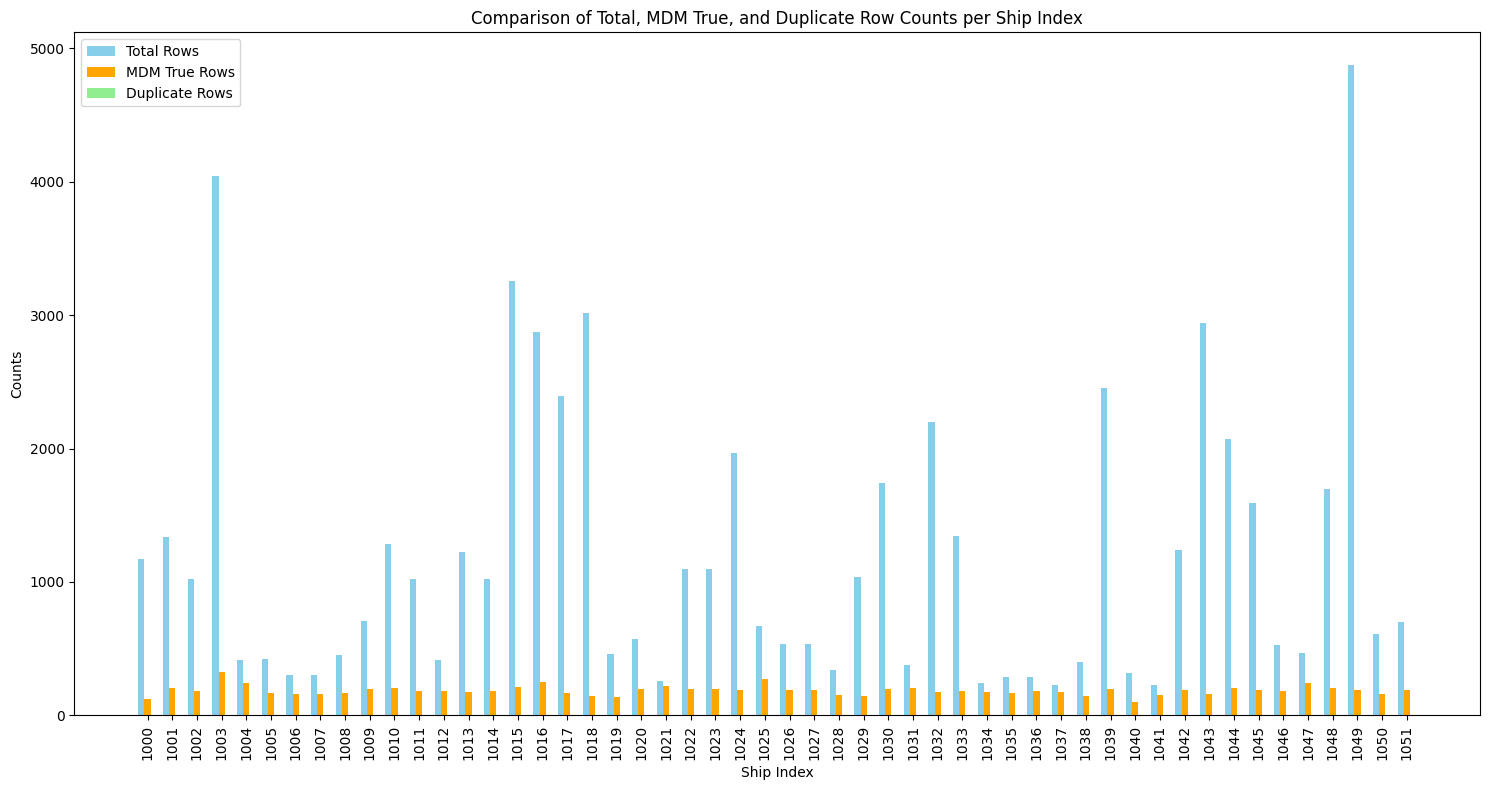

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Load the data
df_test = pd.read_csv('test_with_predictions_with_correct_mapping.csv')

# Count the number of rows for each ships_idx
ship_rows_counts = df_test.groupby('ships_idx').size()

# Filter the DataFrame where 'MDM' is "TRUE" (as a string) and then count the rows for each ships_idx
ship_mdm_counts = df_test[df_test['MDM'] == True].groupby('ships_idx').size()

# Find duplicated rows based on 'p_thing' and 'p_property' within each 'ships_idx'
df_test['is_duplicate_mapping'] = df_test.duplicated(subset=['ships_idx', 'p_thing', 'p_property', 'correct_mapping'], keep=False)

# Set 'is_duplicate_mapping' to False for rows where 'correct_mapping' is False
df_test.loc[df_test['correct_mapping'] == False, 'is_duplicate_mapping'] = False

# Count the number of true duplicates for each ships_idx
duplicate_counts = df_test[df_test['is_duplicate_mapping']].groupby('ships_idx').size()

# Ensure the indices are aligned
indices = list(ship_rows_counts.index.union(ship_mdm_counts.index).union(duplicate_counts.index))
ship_rows_counts = ship_rows_counts.reindex(indices, fill_value=0)
ship_mdm_counts = ship_mdm_counts.reindex(indices, fill_value=0)
duplicate_counts = duplicate_counts.reindex(indices, fill_value=0)

# Create the figure and axis
plt.figure(figsize=(15, 8))

# Define the width of the bars and calculate positions for each group
width = 0.25  # the width of the bars
n = len(indices)  # the number of different ship_idx entries
r1 = range(n)  # positions for the first set of bars
r2 = [x + width for x in r1]  # positions for the second set of bars
r3 = [x + width for x in r2]  # positions for the third set of bars

# Plot the bars
plt.bar(r1, ship_rows_counts, width=width, label='Total Rows', color='skyblue')
plt.bar(r2, ship_mdm_counts, width=width, label='MDM True Rows', color='orange')
plt.bar(r3, duplicate_counts, width=width, label='Duplicate Rows', color='lightgreen')

# Add some useful information to the plot
plt.xlabel('Ship Index')
plt.ylabel('Counts')
plt.title('Comparison of Total, MDM True, and Duplicate Row Counts per Ship Index')
plt.xticks([r + width for r in range(n)], indices, rotation=90)

# Create legend & Show plot
plt.legend()
plt.tight_layout()
plt.show()


Total correct mappings: 8023
Total ship MDM counts: 9692
Average Mapping Accuracy: 82.78%


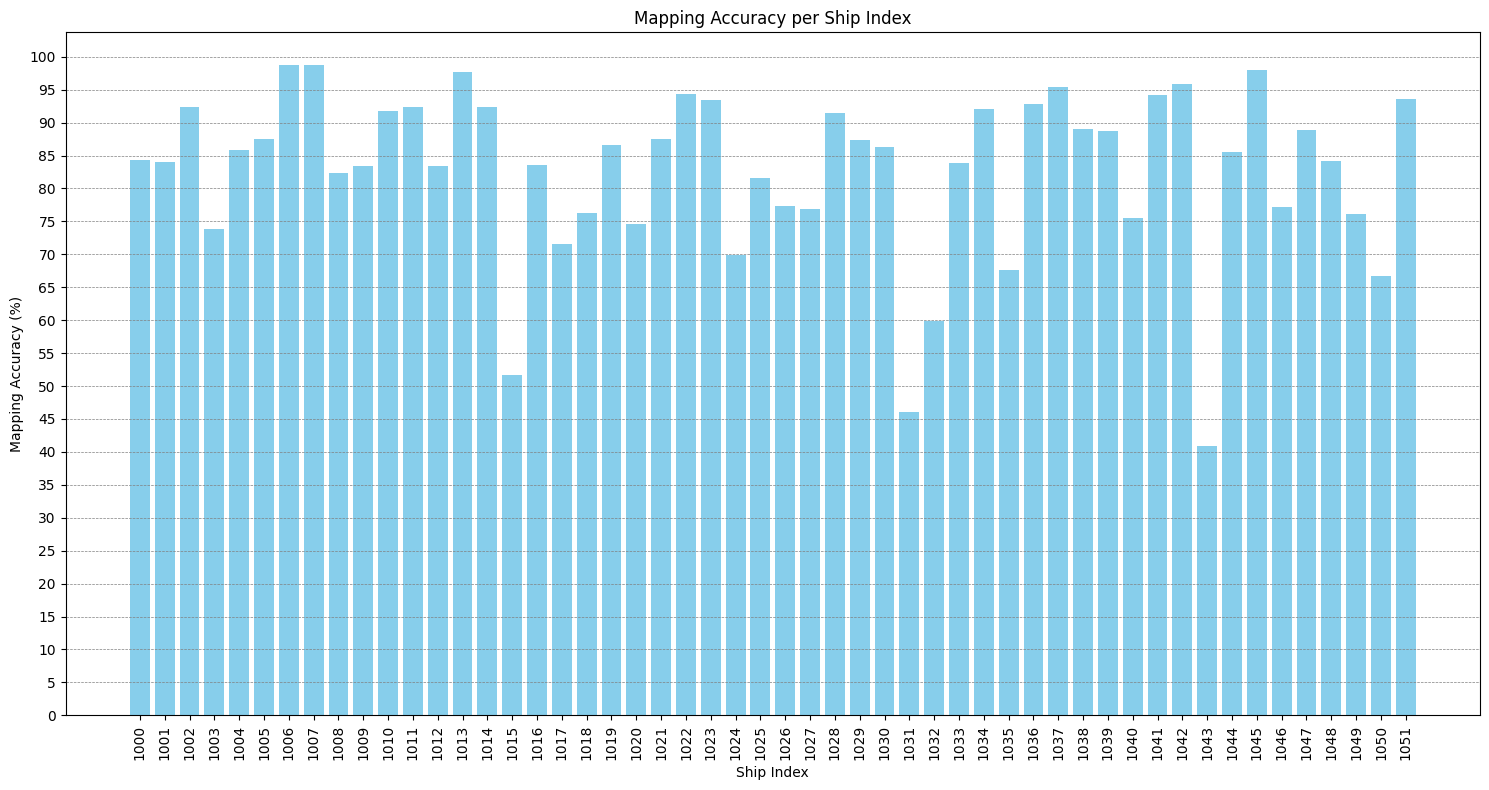

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_test is already defined and contains the necessary data
# Filter the DataFrame where both 'p_thing_correct' and 'p_property_correct' are "TRUE",
# then group by 'ships_idx' and count the occurrences
correct_mappings = df_test[
    (df_test['correct_mapping'] == True)
].groupby('ships_idx').size()

# Combine the three Series into a DataFrame with appropriate column names
result = pd.concat([ship_rows_counts, ship_mdm_counts, correct_mappings], axis=1)
result.columns = ['ship_rows_counts', 'ship_mdm_counts', 'correct_mappings']

# Reset index to turn the index into a regular column if necessary
result = result.reset_index()

# Fill NaN values with 0 where there are no mappings or mdm counts
result['ship_mdm_counts'] = result['ship_mdm_counts'].fillna(0)
result['correct_mappings'] = result['correct_mappings'].fillna(0)

# Calculate mapping accuracy and handle division by zero by replacing infinity with NaN or zero
result['mapping_accuracy'] = result['correct_mappings'] / result['ship_mdm_counts'].replace({0: pd.NA})

# Replace infinite values with NaN if there were division by zero cases
result['mapping_accuracy'] = result['mapping_accuracy'].fillna(0)

# Convert to percentage if desired
result['mapping_accuracy'] *= 100

# Calculate the average mapping accuracy
total_correct_mappings = result['correct_mappings'].sum()
total_ship_mdm_counts = result['ship_mdm_counts'].sum()
average_mapping_accuracy = (total_correct_mappings / total_ship_mdm_counts) * 100 if total_ship_mdm_counts != 0 else 0

# Print the total counts and average mapping accuracy
print(f"Total correct mappings: {total_correct_mappings}")
print(f"Total ship MDM counts: {total_ship_mdm_counts}")
print(f"Average Mapping Accuracy: {average_mapping_accuracy:.2f}%")

plt.figure(figsize=(15, 8))  # Adjust the size as needed
plt.bar(result['ships_idx'], result['mapping_accuracy'], color='skyblue')

plt.title('Mapping Accuracy per Ship Index')
plt.xlabel('Ship Index')
plt.ylabel('Mapping Accuracy (%)')

# Set y-axis ticks to increment by 5
plt.yticks(range(0, 101, 5))  # Assuming the accuracy percentage ranges from 0 to 100

# Add horizontal grid lines for better readability, only horizontal by setting axis='y'
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='grey')

# Rotate x-axis labels to prevent overlap
plt.xticks(result['ships_idx'], rotation=90)

plt.tight_layout()  # Adjust layout to make sure everything fits without overlap
plt.show()
